In [13]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
import sys
import os
import xgboost as xgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import catboost as cat
from IPython.display import clear_output

path = '/home/alexandr/Desktop/study/boosterspro/happy_data_year_rosbank/'
sys.path.append(path) if not path in sys.path else None
import src.utils as utils
from src.model import AveragingModel
import src.location_features as lf


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [15]:
train = pd.read_csv(path+'data/input/train.csv', index_col=0)

In [16]:
test = pd.read_csv(path+'data/working/test_more_addr.csv', index_col=0)

In [17]:
train['isTrain'] = True
test['isTrain'] = False

In [18]:
X = train.append(test, sort=False)

In [19]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8461.0,54.145434,4.319808,42.057080,52.254512,55.061529,56.116543,69.495093
long,8461.0,63.411388,32.742433,19.941530,37.836689,48.813662,84.949400,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [20]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


### Количество банкоматов стоящих по одному адресу

In [21]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [22]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [23]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0


### Расстояния до ближайших банкоматов

In [24]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [25]:
knc = KNeighborsClassifier(metric=distance)

In [26]:
dots = X[['lat','long']].dropna()

In [27]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7fb57f4f3488>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [29]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [30]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots = dots.drop(columns=['lat', 'long'])

In [31]:
X = pd.concat([X,dots], axis=1)

In [32]:
dist_inds = ['distance_1', 'distance_2',  'distance_3',  'distance_4', 'distance_5']

### Город размещения

In [33]:
X = lf.cities(X)

In [34]:
X.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain', 'count', 'distance_1', 'indexes_1', 'distance_2',
       'indexes_2', 'distance_3', 'indexes_3', 'distance_4', 'indexes_4',
       'distance_5', 'indexes_5', 'mean', 'city', 'city_people', 'city_lat',
       'city_long', 'city_dist'],
      dtype='object')

## Facilities

In [35]:
N = 5
fac = lf.facilities(X[['lat', 'long']].dropna(), 'loc', N)
loc_inds = list('loc_'+str(i) for i in range(N))

In [36]:
for i in range(N):
    X['loc_'+str(i)] = np.nan

In [37]:
X.loc[np.where(~X.lat.isna())[0], loc_inds] = fac.values

In [38]:
X.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain', 'count', 'distance_1', 'indexes_1', 'distance_2',
       'indexes_2', 'distance_3', 'indexes_3', 'distance_4', 'indexes_4',
       'distance_5', 'indexes_5', 'mean', 'city', 'city_people', 'city_lat',
       'city_long', 'city_dist', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4'],
      dtype='object')

In [39]:
X['loc_0'].quantile(0.25)

0.04294917799257947

## Feature engineering. Add more features

In [40]:
dev_inds = []
# for i in range(5):
#     dev_inds.append('deviation_{0}'.format(i))
#     X['deviation_{0}'.format(i)] = X['loc_{0}'.format(i)] - X['loc_{0}'.format(i)].quantile(0.3)

In [41]:
X['loc_quantile_50'] = X[loc_inds].quantile(0.5, axis=1)
X['dist_quantile_50'] = X[dist_inds].quantile(0.5, axis=1)
X['loc_std'] = X[loc_inds].std(axis=1)

## Train / test

In [42]:
columns = ['atm_group', 'lat', 'long', 'loc_std', 'count',
                    'mean', 'city', 'city_people', 'city_lat', 
                    'city_long', 'city_dist', 'loc_quantile_50', 'dist_quantile_50'] + loc_inds + dist_inds

X['atm_group'] = X['atm_group'].astype(int)
X['city'] = X['city'].astype(int)

X_ = X[X.isTrain][columns]
Y_ = X.loc[X.isTrain, 'target']

In [43]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_, Y_, test_size=0.2, random_state=2)
X_train

,atm_group,lat,long,loc_std,count,mean,city,city_people,city_lat,city_long,...,loc_0,loc_1,loc_2,loc_3,loc_4,distance_1,distance_2,distance_3,distance_4,distance_5
375,3185,56.468438,84.980994,0.124346,1.0,0.225541,7278,522940.0,56.484704,84.948174,...,0.249143,0.385311,0.388795,0.522806,0.561138,0.106479,0.111161,0.263942,0.298175,0.347949
4841,8083,59.926472,30.347983,0.050766,2.0,0.268531,6788,NaN,NaN,NaN,...,0.052701,0.085886,0.128031,0.166921,0.168482,0.000000,0.104570,0.223478,0.407825,0.606784
3189,5478,57.098367,65.636870,0.232185,1.0,1.068426,7452,581758.0,57.153082,65.534312,...,0.378365,0.691062,0.743364,0.795377,1.023413,0.758995,0.758995,0.758995,1.470391,1.594754
4640,5478,55.024925,82.956066,0.239310,1.0,1.223588,5872,1498921.0,55.028102,82.921057,...,0.321248,0.392075,0.430347,0.786990,0.835269,1.105973,1.151946,1.247956,1.306032,1.306032
4604,5478,NaN,NaN,NaN,NaN,NaN,-1,11514330.0,55.753879,37.620373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,496,51.657870,35.942753,1.875371,1.0,12.778832,1419,NaN,NaN,NaN,...,0.059307,0.111241,0.275664,3.237760,3.854849,9.151750,13.409103,13.568471,13.670816,14.094020
1575,1942,52.838098,40.419840,0.149668,1.0,8.003814,1419,NaN,NaN,NaN,...,6.409054,6.517212,6.678386,6.732386,6.756045,7.054465,8.117009,8.137834,8.203105,8.506656
421,3185,62.044382,129.756388,0.121236,1.0,0.311950,8189,269486.0,62.028027,129.732572,...,0.504773,0.749880,0.753761,0.790917,0.793607,0.192950,0.254332,0.254332,0.402646,0.455489
2558,496,53.055424,158.661910,0.337570,3.0,0.565100,6427,179526.0,53.037021,158.655914,...,0.010954,0.022374,0.322672,0.589082,0.769369,0.000000,0.000000,0.233325,1.153335,1.438843
743,5478,59.930489,30.355349,0.040482,2.0,0.123722,6788,NaN,NaN,NaN,...,0.049858,0.056730,0.073747,0.091115,0.151017,0.000000,0.082905,0.082905,0.207181,0.245620


## LightGBM

In [44]:

def train(depth=12, n_estimators=150):
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = depth,
                            num_iterations=1000,
                            learning_rate = 0.1,
                            num_leaves = 2**(depth-1),
                            boosting = 'gbdt',
                            n_estimators = n_estimators)
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)
    score = rmse(Y_valid, gbm.predict(X_valid))
    return gbm, score
scores = []
models = []
for depth in tqdm_notebook(range(3, 12)):
    model, score = train(depth)
    models.append(model)
    scores.append(score)
    
opt_depth = 5+np.argmin(scores)
gbm_model = models[np.argmin(scores)]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.0065784	valid_0's rmse: 0.0811073
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00581686	valid_0's rmse: 0.0762684
[3]	valid_0's l2: 0.00519798	valid_0's rmse: 0.072097
[4]	valid_0's l2: 0.00469343	valid_0's rmse: 0.0685086
[5]	valid_0's l2: 0.00428085	valid_0's rmse: 0.0654282
[6]	valid_0's l2: 0.00394342	valid_0's rmse: 0.0627967
[7]	valid_0's l2: 0.00366395	valid_0's rmse: 0.0605306
[8]	valid_0's l2: 0.00344022	valid_0's rmse: 0.0586534
[9]	valid_0's l2: 0.00322667	valid_0's rmse: 0.0568038
[10]	valid_0's l2: 0.00307099	valid_0's rmse: 0.0554165
[11]	valid_0's l2: 0.00294115	valid_0's rmse: 0.0542324
[12]	valid_0's l2: 0.00283601	valid_0's rmse: 0.0532542
[13]	valid_0's l2: 0.00272775	valid_0's rmse: 0.0522278
[14]	valid_0's l2: 0.0026574	valid_0's rmse: 0.0515499
[15]	valid_0's l2: 0.00258022	valid_0's rmse: 0.0507959
[16]	valid_0's l2: 0.00253204	valid_0's rmse: 0.0503194
[17]	valid_0's l2: 0.0024878	valid_0's rmse: 0.0498778


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00653688	valid_0's rmse: 0.080851
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00574448	valid_0's rmse: 0.0757923
[3]	valid_0's l2: 0.0051077	valid_0's rmse: 0.0714682
[4]	valid_0's l2: 0.00458178	valid_0's rmse: 0.0676889
[5]	valid_0's l2: 0.00415545	valid_0's rmse: 0.0644628
[6]	valid_0's l2: 0.00380335	valid_0's rmse: 0.0616713
[7]	valid_0's l2: 0.00352121	valid_0's rmse: 0.0593398
[8]	valid_0's l2: 0.0032938	valid_0's rmse: 0.0573917
[9]	valid_0's l2: 0.00310483	valid_0's rmse: 0.055721
[10]	valid_0's l2: 0.00292596	valid_0's rmse: 0.0540921
[11]	valid_0's l2: 0.00278588	valid_0's rmse: 0.0527815
[12]	valid_0's l2: 0.00267727	valid_0's rmse: 0.0517424
[13]	valid_0's l2: 0.00257893	valid_0's rmse: 0.0507831
[14]	valid_0's l2: 0.00250236	valid_0's rmse: 0.0500236
[15]	valid_0's l2: 0.00242808	valid_0's rmse: 0.0492756
[16]	valid_0's l2: 0.00237121	valid_0's rmse: 0.0486951
[17]	valid_0's l2: 0.00232105	valid_0's rmse: 0.0481772


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's l2: 0.0020782	valid_0's rmse: 0.0455873
[24]	valid_0's l2: 0.00206793	valid_0's rmse: 0.0454745
[25]	valid_0's l2: 0.00205745	valid_0's rmse: 0.0453591
[26]	valid_0's l2: 0.00204711	valid_0's rmse: 0.045245
[27]	valid_0's l2: 0.00203756	valid_0's rmse: 0.0451393
[28]	valid_0's l2: 0.00203226	valid_0's rmse: 0.0450806
[29]	valid_0's l2: 0.00202032	valid_0's rmse: 0.044948
[30]	valid_0's l2: 0.00201463	valid_0's rmse: 0.0448846
[31]	valid_0's l2: 0.00200577	valid_0's rmse: 0.0447858
[32]	valid_0's l2: 0.00199914	valid_0's rmse: 0.0447118
[33]	valid_0's l2: 0.00199615	valid_0's rmse: 0.0446783
[34]	valid_0's l2: 0.00199075	valid_0's rmse: 0.0446178
[35]	valid_0's l2: 0.00198558	valid_0's rmse: 0.0445599
[36]	valid_0's l2: 0.00198286	valid_0's rmse: 0.0445293
[37]	valid_0's l2: 0.00197252	valid_0's rmse: 0.044413
[38]	valid_0's l2: 0.00197052	valid_0's rmse: 0.0443905
[39]	valid_0's l2: 0.00196749	valid_0's rmse: 0.0443565
[40]	valid_0's l2: 0.00196411	valid_0's rmse: 0.0443

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.0064952	valid_0's rmse: 0.0805928
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00566804	valid_0's rmse: 0.0752864
[3]	valid_0's l2: 0.00499646	valid_0's rmse: 0.0706856
[4]	valid_0's l2: 0.00444905	valid_0's rmse: 0.0667012
[5]	valid_0's l2: 0.00400343	valid_0's rmse: 0.0632727
[6]	valid_0's l2: 0.00363977	valid_0's rmse: 0.0603305
[7]	valid_0's l2: 0.00334142	valid_0's rmse: 0.057805
[8]	valid_0's l2: 0.00310183	valid_0's rmse: 0.0556941
[9]	valid_0's l2: 0.00289276	valid_0's rmse: 0.0537844
[10]	valid_0's l2: 0.00272472	valid_0's rmse: 0.0521988
[11]	valid_0's l2: 0.00259373	valid_0's rmse: 0.0509286
[12]	valid_0's l2: 0.00247829	valid_0's rmse: 0.0497824
[13]	valid_0's l2: 0.00239351	valid_0's rmse: 0.0489235
[14]	valid_0's l2: 0.00231583	valid_0's rmse: 0.048123
[15]	valid_0's l2: 0.00225954	valid_0's rmse: 0.0475346
[16]	valid_0's l2: 0.00220596	valid_0's rmse: 0.0469677
[17]	valid_0's l2: 0.00216128	valid_0's rmse: 0.0464895

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's l2: 0.00360979	valid_0's rmse: 0.0600815
[7]	valid_0's l2: 0.00331396	valid_0's rmse: 0.057567
[8]	valid_0's l2: 0.00307048	valid_0's rmse: 0.0554119
[9]	valid_0's l2: 0.00287214	valid_0's rmse: 0.0535923
[10]	valid_0's l2: 0.00271041	valid_0's rmse: 0.0520616
[11]	valid_0's l2: 0.00257604	valid_0's rmse: 0.0507547
[12]	valid_0's l2: 0.00246987	valid_0's rmse: 0.0496978
[13]	valid_0's l2: 0.00236863	valid_0's rmse: 0.0486686
[14]	valid_0's l2: 0.00229827	valid_0's rmse: 0.0479402
[15]	valid_0's l2: 0.00223167	valid_0's rmse: 0.0472406
[16]	valid_0's l2: 0.00217352	valid_0's rmse: 0.0466211
[17]	valid_0's l2: 0.0021338	valid_0's rmse: 0.0461931
[18]	valid_0's l2: 0.00210252	valid_0's rmse: 0.0458532
[19]	valid_0's l2: 0.00207009	valid_0's rmse: 0.0454982
[20]	valid_0's l2: 0.00204891	valid_0's rmse: 0.0452648
[21]	valid_0's l2: 0.00203126	valid_0's rmse: 0.0450695
[22]	valid_0's l2: 0.00201632	valid_0's rmse: 0.0449034
[23]	valid_0's l2: 0.0020026	valid_0's rmse: 0.0447504

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's l2: 0.00495816	valid_0's rmse: 0.0704142
[4]	valid_0's l2: 0.0044072	valid_0's rmse: 0.0663867
[5]	valid_0's l2: 0.00395533	valid_0's rmse: 0.0628914
[6]	valid_0's l2: 0.00359666	valid_0's rmse: 0.0599722
[7]	valid_0's l2: 0.00329087	valid_0's rmse: 0.0573661
[8]	valid_0's l2: 0.00305314	valid_0's rmse: 0.0552552
[9]	valid_0's l2: 0.00284968	valid_0's rmse: 0.0533824
[10]	valid_0's l2: 0.00269385	valid_0's rmse: 0.0519023
[11]	valid_0's l2: 0.00256507	valid_0's rmse: 0.0506465
[12]	valid_0's l2: 0.0024536	valid_0's rmse: 0.0495338
[13]	valid_0's l2: 0.00236411	valid_0's rmse: 0.0486221
[14]	valid_0's l2: 0.00229176	valid_0's rmse: 0.0478723
[15]	valid_0's l2: 0.00222574	valid_0's rmse: 0.0471778
[16]	valid_0's l2: 0.00217598	valid_0's rmse: 0.0466475
[17]	valid_0's l2: 0.00213656	valid_0's rmse: 0.0462229
[18]	valid_0's l2: 0.00210305	valid_0's rmse: 0.045859
[19]	valid_0's l2: 0.00207244	valid_0's rmse: 0.045524
[20]	valid_0's l2: 0.00204983	valid_0's rmse: 0.0452751
[21

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.0064771	valid_0's rmse: 0.0804804
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00562645	valid_0's rmse: 0.0750097
[3]	valid_0's l2: 0.00496267	valid_0's rmse: 0.0704462
[4]	valid_0's l2: 0.00440705	valid_0's rmse: 0.0663856
[5]	valid_0's l2: 0.00395316	valid_0's rmse: 0.0628742
[6]	valid_0's l2: 0.00358687	valid_0's rmse: 0.0598905
[7]	valid_0's l2: 0.00328171	valid_0's rmse: 0.0572863
[8]	valid_0's l2: 0.00303605	valid_0's rmse: 0.0551004
[9]	valid_0's l2: 0.00283815	valid_0's rmse: 0.0532743
[10]	valid_0's l2: 0.00267855	valid_0's rmse: 0.0517547
[11]	valid_0's l2: 0.00254663	valid_0's rmse: 0.0504642
[12]	valid_0's l2: 0.00243499	valid_0's rmse: 0.0493456
[13]	valid_0's l2: 0.0023513	valid_0's rmse: 0.0484902
[14]	valid_0's l2: 0.00227356	valid_0's rmse: 0.0476819
[15]	valid_0's l2: 0.00221864	valid_0's rmse: 0.0471024
[16]	valid_0's l2: 0.00216998	valid_0's rmse: 0.0465831
[17]	valid_0's l2: 0.00213352	valid_0's rmse: 0.046190

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00647481	valid_0's rmse: 0.0804662
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00562494	valid_0's rmse: 0.0749996
[3]	valid_0's l2: 0.00495629	valid_0's rmse: 0.0704009
[4]	valid_0's l2: 0.004405	valid_0's rmse: 0.0663702
[5]	valid_0's l2: 0.00394385	valid_0's rmse: 0.0628001
[6]	valid_0's l2: 0.0035778	valid_0's rmse: 0.0598147
[7]	valid_0's l2: 0.0032749	valid_0's rmse: 0.0572267
[8]	valid_0's l2: 0.00303298	valid_0's rmse: 0.0550725
[9]	valid_0's l2: 0.00283462	valid_0's rmse: 0.0532412
[10]	valid_0's l2: 0.00267027	valid_0's rmse: 0.0516747
[11]	valid_0's l2: 0.00253983	valid_0's rmse: 0.0503968
[12]	valid_0's l2: 0.00242718	valid_0's rmse: 0.0492664
[13]	valid_0's l2: 0.00234404	valid_0's rmse: 0.0484153
[14]	valid_0's l2: 0.00227571	valid_0's rmse: 0.0477044
[15]	valid_0's l2: 0.00220948	valid_0's rmse: 0.0470051
[16]	valid_0's l2: 0.00215675	valid_0's rmse: 0.0464408
[17]	valid_0's l2: 0.00212351	valid_0's rmse: 0.0460815


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.0064727	valid_0's rmse: 0.0804531
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00562292	valid_0's rmse: 0.0749861
[3]	valid_0's l2: 0.00494764	valid_0's rmse: 0.0703395
[4]	valid_0's l2: 0.004388	valid_0's rmse: 0.066242
[5]	valid_0's l2: 0.00393005	valid_0's rmse: 0.0626901
[6]	valid_0's l2: 0.00357005	valid_0's rmse: 0.0597499
[7]	valid_0's l2: 0.00327287	valid_0's rmse: 0.057209
[8]	valid_0's l2: 0.00303262	valid_0's rmse: 0.0550692
[9]	valid_0's l2: 0.00283688	valid_0's rmse: 0.0532624
[10]	valid_0's l2: 0.00268022	valid_0's rmse: 0.0517708
[11]	valid_0's l2: 0.00253846	valid_0's rmse: 0.0503832
[12]	valid_0's l2: 0.00242765	valid_0's rmse: 0.0492712
[13]	valid_0's l2: 0.00233871	valid_0's rmse: 0.0483602
[14]	valid_0's l2: 0.00226539	valid_0's rmse: 0.0475961
[15]	valid_0's l2: 0.00220717	valid_0's rmse: 0.0469805
[16]	valid_0's l2: 0.00215829	valid_0's rmse: 0.0464573
[17]	valid_0's l2: 0.00211972	valid_0's rmse: 0.0460404
[

0.04308438739854646 0.04308438739854646


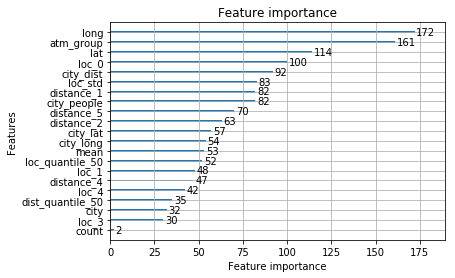

In [45]:
lgb.plot_importance(gbm_model)
print(rmse(Y_valid, gbm_model.predict(X_valid)), scores[opt_depth-5])

In [72]:
gbm_params = gbm_model.get_params()
print(gbm_params)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_iterations': 1000, 'boosting': 'gbdt'}


## XGBoost


In [47]:
def train_xgb(params, X_train, Y_train):
    xg_reg = xgb.XGBRegressor(**params)
    xg_reg.fit(X_train, Y_train)
    score = rmse(Y_valid, xg_reg.predict(X_valid))
    return xg_reg, score

In [48]:
scores = []
models = []

conf = {
    'seed': 1,
    'subsample': 0.8,
    'max_depth': 7,
    'n_estimators': 150,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

for depth in tqdm_notebook(range(4, 8)):
    for n_estimators in range(100, 250, 20):
        conf['max_depth'] = depth
        conf['max_leaf_nodes'] = 2**(depth-1)
        conf['n_estimators'] = n_estimators
        model, score = train_xgb(conf, X_train, Y_train)
        models.append(model)
        scores.append(score)
        print('num of estimators:', n_estimators,
              'depth:', depth, 
              'score:', score, '\n')

xgb_model = models[np.argmin(scores)]
score = scores[np.argmin(scores)]

num of estimators: 100 depth: 4 score: 0.04360807870538771 

num of estimators: 120 depth: 4 score: 0.04357670618077912 

num of estimators: 140 depth: 4 score: 0.043424607134743484 

num of estimators: 160 depth: 4 score: 0.04339944197783605 

num of estimators: 180 depth: 4 score: 0.043373706469411105 

num of estimators: 200 depth: 4 score: 0.04334593910820231 

num of estimators: 220 depth: 4 score: 0.04340671034263022 

num of estimators: 240 depth: 4 score: 0.043355802078891406 

num of estimators: 100 depth: 5 score: 0.04301713046787839 

num of estimators: 120 depth: 5 score: 0.042889415647025614 

num of estimators: 140 depth: 5 score: 0.04273459045303581 

num of estimators: 160 depth: 5 score: 0.0427752731314412 

num of estimators: 180 depth: 5 score: 0.04280100862098746 

num of estimators: 200 depth: 5 score: 0.04278013029465488 

num of estimators: 220 depth: 5 score: 0.042825193274046304 

num of estimators: 240 depth: 5 score: 0.04289877005032284 

num of estimators: 1

0.04273459045303581 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, max_leaf_nodes=16,
       min_child_weight=1, missing=None, n_estimators=140, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8)


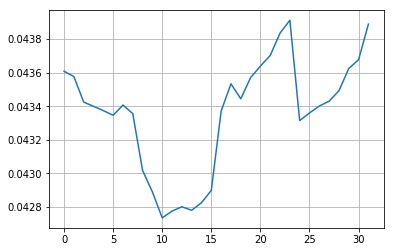

In [49]:
xgb_params = xgb_model.get_params()
print(score, '\n', xgb_model)
plt.plot(scores)
plt.grid()

## Catboost

In [50]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [51]:
categorical_features = ['atm_group', 'city']
categorical_index = column_index(X_train, categorical_features)
categorical_index

array([0, 6])

0:	learn: 0.0802318	test: 0.0809380	best: 0.0809380 (0)	total: 87.4ms	remaining: 1m 27s
75:	learn: 0.0460856	test: 0.0446465	best: 0.0446465 (75)	total: 686ms	remaining: 8.34s
150:	learn: 0.0447213	test: 0.0440493	best: 0.0440478 (148)	total: 1.39s	remaining: 7.81s
225:	learn: 0.0440160	test: 0.0438607	best: 0.0438561 (223)	total: 1.88s	remaining: 6.43s
300:	learn: 0.0434131	test: 0.0436857	best: 0.0436857 (300)	total: 2.47s	remaining: 5.73s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04368567957
bestIteration = 300

Shrink model to first 301 iterations.
depth: 4 score: 0.0436856795497199 



0:	learn: 0.0801944	test: 0.0808648	best: 0.0808648 (0)	total: 40ms	remaining: 40s
75:	learn: 0.0454713	test: 0.0445621	best: 0.0445621 (75)	total: 880ms	remaining: 10.7s
150:	learn: 0.0440924	test: 0.0441855	best: 0.0441855 (150)	total: 1.67s	remaining: 9.41s
225:	learn: 0.0431321	test: 0.0440329	best: 0.0440134 (213)	total: 2.44s	remaining: 8.35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04401341417
bestIteration = 213

Shrink model to first 214 iterations.
depth: 5 score: 0.044013414147713203 



0:	learn: 0.0801988	test: 0.0808685	best: 0.0808685 (0)	total: 33.1ms	remaining: 33s
75:	learn: 0.0452590	test: 0.0444465	best: 0.0444465 (75)	total: 1.22s	remaining: 14.8s
150:	learn: 0.0435281	test: 0.0440097	best: 0.0440003 (148)	total: 2.73s	remaining: 15.3s
225:	learn: 0.0423990	test: 0.0438648	best: 0.0438648 (225)	total: 3.91s	remaining: 13.4s
300:	learn: 0.0417031	test: 0.0437955	best: 0.0437740 (291)	total: 5.17s	remaining: 12s
375:	learn: 0.0411548	test: 0.0437047	best: 0.0437047 (375)	total: 6.38s	remaining: 10.6s
450:	learn: 0.0406687	test: 0.0435975	best: 0.0435871 (440)	total: 7.72s	remaining: 9.39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04358137603
bestIteration = 461

Shrink model to first 462 iterations.
depth: 6 score: 0.04358137601238155 



0:	learn: 0.0802452	test: 0.0809298	best: 0.0809298 (0)	total: 91.8ms	remaining: 1m 31s
75:	learn: 0.0447759	test: 0.0443028	best: 0.0443028 (75)	total: 1.75s	remaining: 21.3s
150:	learn: 0.0430604	test: 0.0438752	best: 0.0438752 (150)	total: 3.38s	remaining: 19s
225:	learn: 0.0419050	test: 0.0435104	best: 0.0434972 (222)	total: 5.21s	remaining: 17.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04343345507
bestIteration = 236

Shrink model to first 237 iterations.
depth: 7 score: 0.0434334550403428 



0:	learn: 0.0802383	test: 0.0809289	best: 0.0809289 (0)	total: 120ms	remaining: 2m
75:	learn: 0.0442499	test: 0.0444082	best: 0.0443790 (72)	total: 3.4s	remaining: 41.3s
150:	learn: 0.0423103	test: 0.0437999	best: 0.0437999 (150)	total: 6.04s	remaining: 34s
225:	learn: 0.0412609	test: 0.0435374	best: 0.0435292 (221)	total: 8.65s	remaining: 29.6s
300:	learn: 0.0402364	test: 0.0433611	best: 0.0433464 (296)	total: 11.7s	remaining: 27.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04334635209
bestIteration = 296

Shrink model to first 297 iterations.
depth: 8 score: 0.0433463520594415 



0:	learn: 0.0802903	test: 0.0810523	best: 0.0810523 (0)	total: 162ms	remaining: 2m 42s
75:	learn: 0.0435231	test: 0.0441598	best: 0.0441576 (71)	total: 6.21s	remaining: 1m 15s
150:	learn: 0.0414117	test: 0.0435418	best: 0.0435353 (147)	total: 12.1s	remaining: 1m 8s
225:	learn: 0.0403125	test: 0.0433032	best: 0.0433032 (225)	total: 17.3s	remaining: 59.1s
300:	learn: 0.0394371	test: 0.0432319	best: 0.0432319 (300)	total: 21.9s	remaining: 50.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04319453053
bestIteration = 313

Shrink model to first 314 iterations.
depth: 9 score: 0.04319453052122147 


0.04319453052122147 <catboost.core.CatBoostRegressor object at 0x7fb57f05d208>


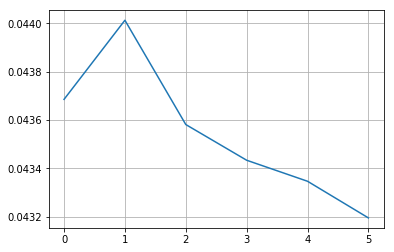

In [52]:
def train_catboost(depth, X_train, Y_train, X_valid, Y_valid):
    cat_model = cat.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=depth,
        eval_metric='RMSE',
        random_seed=1,
        od_type='Iter',
        metric_period=75,
    )


    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid),
                 cat_features=categorical_index,
                 use_best_model=True)
    
    score = rmse(Y_valid, cat_model.predict(X_valid))
    return cat_model, score

    
scores = []
models = []

for depth in tqdm_notebook(range(4, 10)):
    model, score = train_catboost(depth, X_train, Y_train, X_valid, Y_valid)
    models.append(model)
    scores.append(score)
    print('depth:', depth, 
          'score:', score, '\n')

cat_model = models[np.argmin(scores)]
score = scores[np.argmin(scores)]
print(score, cat_model)
plt.plot(scores)
plt.grid()

In [53]:
cat_params = cat_model.get_params()

## Composite Models

## Stacking model

In [54]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.svm import SVR

cat_params_ = cat_params.copy()
cat_params_['iterations'] = 100

ensemble = SuperLearner(scorer=rmse, random_state=1)
ensemble.add([cat.CatBoostRegressor(cat_features=categorical_index, **cat_params_), 
              cat.CatBoostRegressor(cat_features=categorical_index), 
              xgb.XGBRegressor(**xgb_params), 
              xgb.XGBRegressor(), 
              lgb.LGBMRegressor(depth=6, num_leaves=2**(6-1)),
              lgb.LGBMRegressor(depth=4, num_leaves=2**(4-1))
             ])

# ensemble.add( [xgb.XGBRegressor(), lgb.LGBMRegressor()] )
ensemble.add_meta(xgb.XGBRegressor())
ensemble.fit(X_train, Y_train)
clear_output()
preds = ensemble.predict(X_valid)
print(rmse(Y_valid, preds))

0.043032148803222675


In [55]:
pd.DataFrame(ensemble.data)

,score-m,score-s,ft-m,ft-s,pt-m,pt-s
layer-1/catboostregressor-1,0.046642,0.000389,22.803267,1.028483,0.080237,0.006635
layer-1/catboostregressor-2,0.046155,0.000390,55.117581,1.008159,0.045533,0.007556
layer-1/lgbmregressor-1,0.047345,0.000326,6.372272,0.434783,0.102159,0.019854
layer-1/lgbmregressor-2,0.046635,0.000163,1.950529,0.001355,0.072262,0.007956
layer-1/xgbregressor-1,0.046659,0.000122,5.628468,0.371034,0.043750,0.000429
layer-1/xgbregressor-2,0.046749,0.000054,1.585080,0.008674,0.014082,0.000311


### Averaging model

In [56]:
from bayes_opt import BayesianOptimization

pbounds = {
    'cat_weight': (0, 1),
    'xgb_weight': (0, 1),
    'lgb_weight': (0, 1),
#     'ens_weight': (0, 1)
}

def opt_func(cat_weight, xgb_weight, lgb_weight):
    av_model = AveragingModel([
        cat_model, xgb_model, gbm_model], 
        pretrained=True, 
        weights=np.array((cat_weight, xgb_weight, lgb_weight)))

    score = rmse(Y_valid, av_model.predict(X_valid))
    del av_model
    return -score

optimizer = BayesianOptimization(
    f = opt_func,
    pbounds = pbounds,
    random_state = 1
)
    
#     kf = KFold(n_splits=5)
#     for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

In [57]:
optimizer.maximize(
    init_points=10,
    n_iter=10
)

|   iter    |  target   | cat_we... | lgb_we... | xgb_we... |
-------------------------------------------------------------
|  1        | -0.04285  |  0.417    |  0.7203   |  0.000114 |
|  2        | -0.04271  |  0.3023   |  0.1468   |  0.09234  |
|  3        | -0.04256  |  0.1863   |  0.3456   |  0.3968   |
|  4        | -0.04255  |  0.5388   |  0.4192   |  0.6852   |
|  5        | -0.0429   |  0.2045   |  0.8781   |  0.02739  |
|  6        | -0.04258  |  0.6705   |  0.4173   |  0.5587   |
|  7        | -0.04256  |  0.1404   |  0.1981   |  0.8007   |
|  8        | -0.0426   |  0.9683   |  0.3134   |  0.6923   |
|  9        | -0.0428   |  0.8764   |  0.8946   |  0.08504  |
|  10       | -0.04261  |  0.03905  |  0.1698   |  0.8781   |
|  11       | -0.04259  |  0.01773  |  0.4086   |  0.8022   |
|  12       | -0.04259  |  0.1611   |  0.9096   |  0.994    |
|  13       | -0.04265  |  0.7602   |  0.7436   |  0.4083   |
|  14       | -0.04296  |  0.9857   |  0.1218   |  0.08094  |
|  15   

In [58]:
opt_params = optimizer.max['params']

In [59]:
av_model = AveragingModel((cat_model, xgb_model, gbm_model), 
                         pretrained=True, 
                         weights = np.array((
                             opt_params['cat_weight'], 
                             opt_params['xgb_weight'], 
                             opt_params['lgb_weight'], 
                         )))
print('optimal score:', rmse(Y_valid, av_model.predict(X_valid)))

optimal score: 0.042550900282448297


# Bagging

In [67]:
from sklearn.ensemble import BaggingRegressor
from src.model import BaggingModel

In [75]:
base_estimator = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, max_leaf_nodes=16,
       min_child_weight=1, missing=None, n_estimators=140, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.8)

bagging_estimator = BaggingModel(base_estimator, 10)
bagging_estimator.fit(X_train.values, Y_train.values)
print(rmse(Y_valid, bagging_estimator.predict(X_valid.values)))

0.04576410231547161
0.04483510717871064
0.0455540729037201
0.04955895328972704
0.046948704579027715
0.04575096301120902
0.04123325355138778
0.04392917466074778
0.04406326298710586
0.043388964187972105
0.04271007719620314


## Submit

In [60]:
X_test = X[~X.isTrain][columns]

In [61]:
submit = pd.DataFrame(av_model.predict(X_test), index=test.index,columns=['target'])

In [62]:
submit.to_csv('../submissions/av_model_4.csv')

In [63]:
X_test.columns

Index(['atm_group', 'lat', 'long', 'loc_std', 'count', 'mean', 'city',
       'city_people', 'city_lat', 'city_long', 'city_dist', 'loc_quantile_50',
       'dist_quantile_50', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4',
       'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5'],
      dtype='object')